In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
from PIL import Image
import torch
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tifffile import tifffile 


## Initial Augmentation Tests

In [10]:
def plot_images_with_bboxes(sample_info, title=None):

    src_SI = 'swissImage_50cm_patches/' + sample_info['file_name']
    src_SS = 'swissSURFACE3D_patches/' + sample_info['file_name']
    src_HS = 'swissSURFACE3D_hillshade_patches/' + sample_info['file_name']

    # Read and draw the bounding boxes
    bboxes = sample_info['rocks_annotations']  # Assuming each image has a 'rocks_annotations' field containing the bounding boxes

    # Open and display the image
    image = tifffile.imread(src_SI)
    f, ax = plt.subplots(1, 3)
    f.set_figheight(5)
    f.set_figwidth(15)

    # Set the title if provided
    if title:
        f.suptitle(title)

    # Plot swissIMAGE
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].title.set_text('swissIMAGE')
    for box in bboxes:
        x, y = box['pixel_within_patch_coordinates']
        rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)

    # Plot swissSURFACE3D
    dsm = tifffile.imread(src_SS)
    ax[1].imshow(dsm, cmap='gist_gray')
    ax[1].axis('off')
    ax[1].title.set_text('swissSURFACE3D')
    for box in bboxes:
        x, y = box['pixel_within_patch_coordinates']
        rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)

    # Plot Hillshade
    hs = tifffile.imread(src_HS)
    ax[2].imshow(hs, cmap='gist_gray')
    ax[2].axis('off')
    ax[2].title.set_text('Hillshade')
    for box in bboxes:
        x, y = box['pixel_within_patch_coordinates']
        rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    # Show the plot with bounding boxes
    plt.show()


Looking at the the first images: 2581_1126_0_2.tif
Looking at rocks annotations for the first images:
 {'rock_id': 1475.0, 'abs_rock_coordinates': [2581037.04, 1126409.36], 'pixel_within_patch_coordinates': [77.0, 250.0], 'relative_within_patch_location': [0.12, 0.39]}


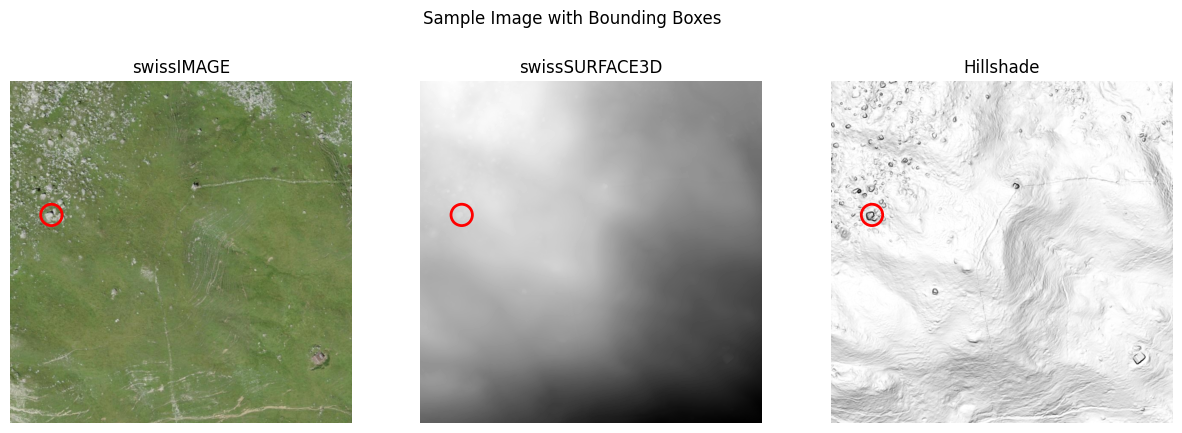

In [11]:
# Illustration of some samples coming from the dataset
json_file_path = 'large_rock_dataset.json'

# Load the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)
dataset =data['dataset']
sample_info = dataset[2]
print('Looking at the the first images:', sample_info ['file_name'])
print('Looking at rocks annotations for the first images:\n', sample_info['rocks_annotations'][0])

plot_images_with_bboxes(sample_info, title='Sample Image with Bounding Boxes')

## Brightness Augmentation

Image SI Shape: (640, 640, 3)


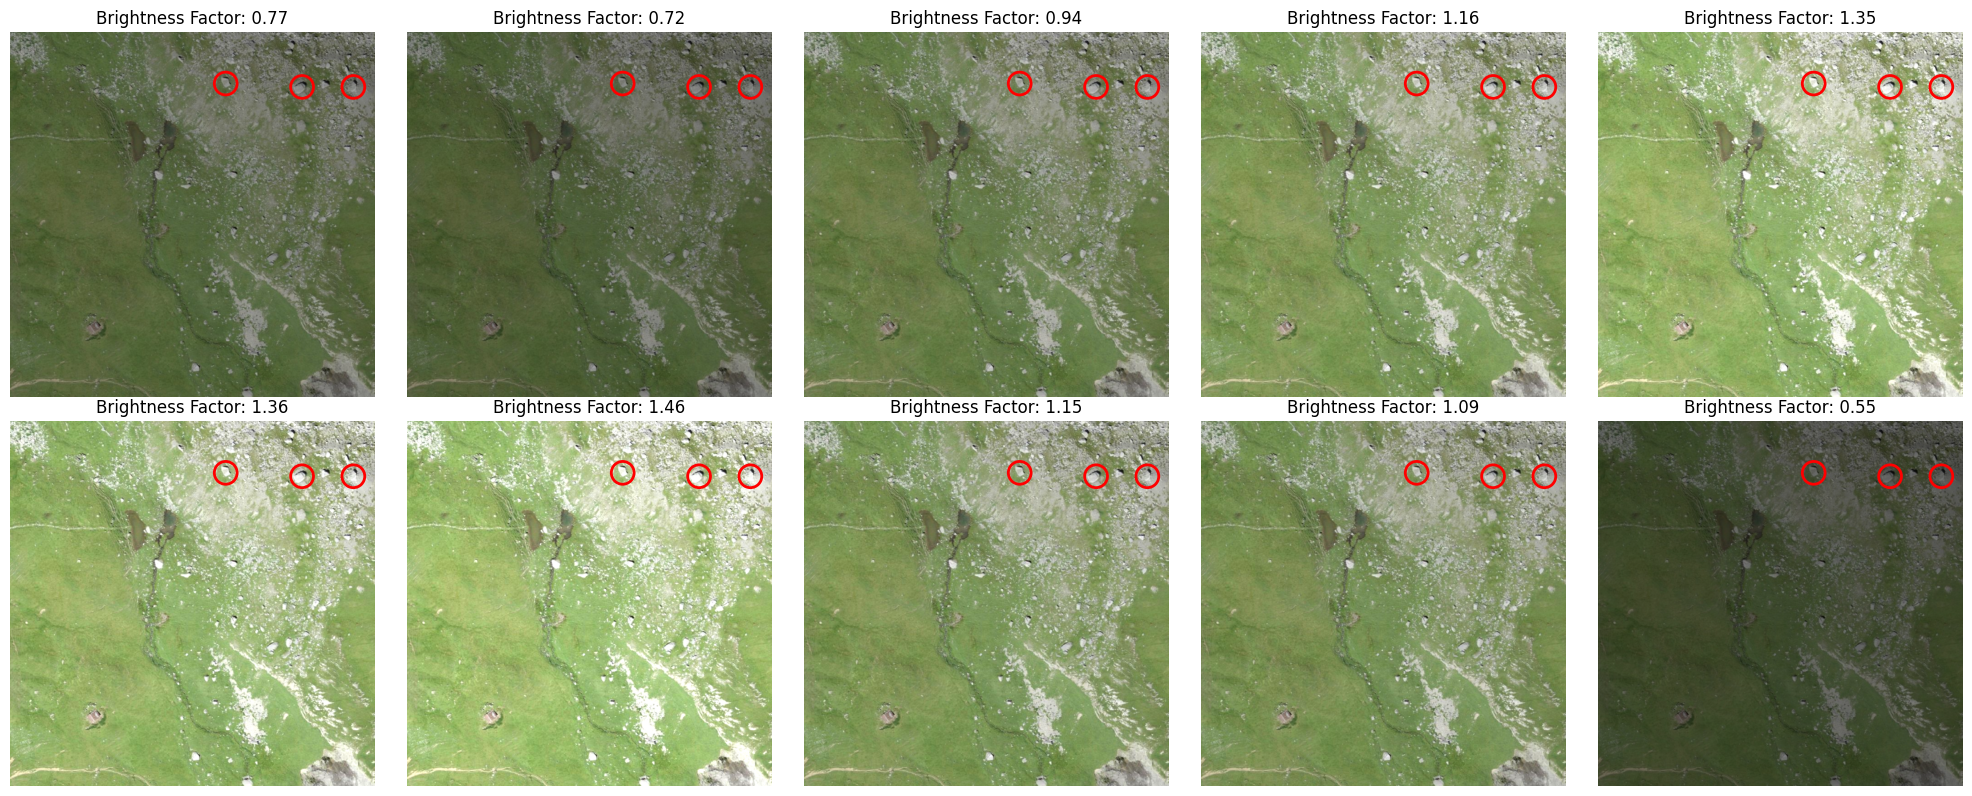

In [ ]:
# Apply the brightness augmentation
sample_info = dataset[6]
src_SI = 'swissImage_50cm_patches/' + sample_info['file_name']
bboxes = sample_info['rocks_annotations']
# Read the image
image_SI = tifffile.imread(src_SI)
print("Image SI Shape:", image_SI.shape)

def adjust_brightness(image, brightness_range=(0.5, 1.5)):
    # Convert RGB image to tensor and permute dimensions (H, W, C) -> (C, H, W)
    image_tensor = torch.tensor(image).permute(2, 0, 1)  # Ensure shape is (C, H, W)

    ################################################################
    # WAY 1 --> this way is just used to print the brightness factor
    ################################################################
    # Sample a random brightness factor
    brightness_factor = random.uniform(*brightness_range)
    # Adjust brightness
    image_aug = transforms.functional.adjust_brightness(image_tensor, brightness_factor)

    ################################################################
    #WAY 2 --> this way is used to apply the brightness factor later
    ################################################################
    # brightness_transform = transforms.ColorJitter(brightness=0.5)  # Adjust brightness by ±50%
    # image_aug = brightness_transform(image_tensor)  # RGB image

    # Convert back to NumPy (C, H, W) -> (H, W, C)
    return image_aug.permute(1, 2, 0).numpy(), brightness_factor

# Create a 3x3 subplot for different brightness augmentations
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i in range(2):
    for j in range(5):
        # Apply random brightness adjustment
        image_SI_aug_np, brightness_factor = adjust_brightness(image_SI)
        # Plot the augmented image
        ax[i, j].imshow(image_SI_aug_np.astype("uint8"))
        ax[i, j].axis("off")
        ax[i, j].set_title(f"Brightness Factor: {brightness_factor:.2f}")
        for box in bboxes:
            x, y = box["pixel_within_patch_coordinates"]
            rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor="r", facecolor="none")
            ax[i, j].add_patch(rect)

plt.tight_layout()
plt.show()


I think brightness augmentation is only usefull for the RGB (different lighting conditions) images and not the other two, because I think DSM intensities represent elevation, altering brightness can change the meaning

## Random Flipping

I think randomflip, mirror, etc, we can do to all images, problem here will be to change the coordinates of the bbox

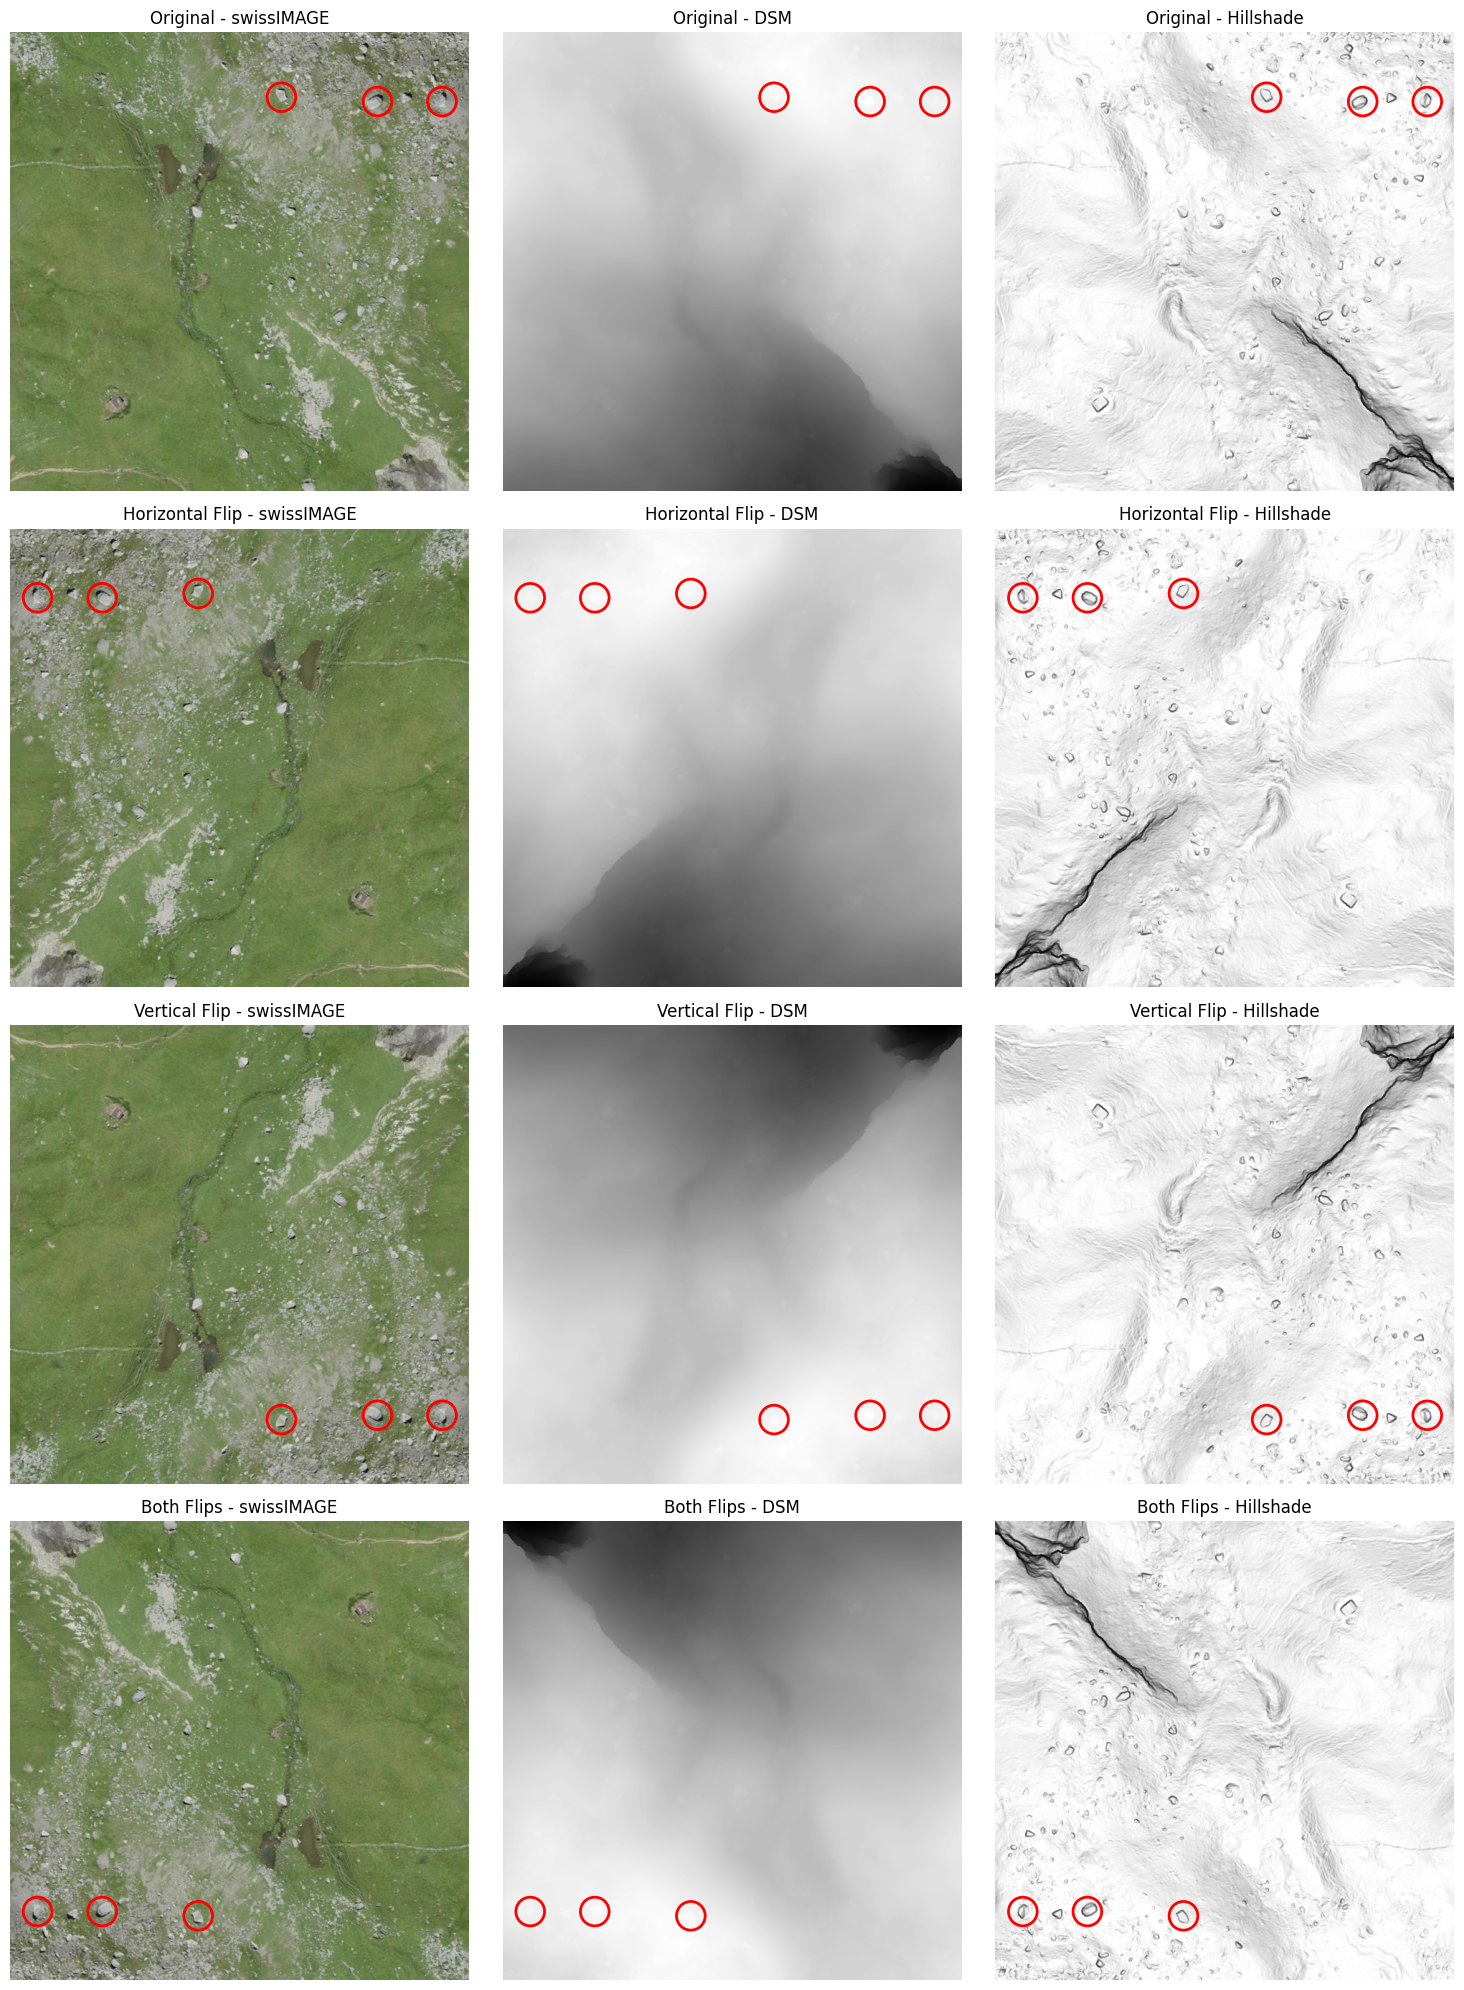

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile
import numpy as np

def flip_image_and_boxes(image, bboxes, flip_type, image_shape):
    """
    Flip image and adjust bounding boxes.

    Args:
        image: The image array (NumPy array).
        bboxes: List of bounding boxes with pixel coordinates.
        flip_type: 'horizontal', 'vertical', or 'both'.
        image_shape: Tuple containing the shape of the image (height, width).

    Returns:
        Flipped image and updated bounding boxes.
    """
    h, w = image_shape
    flipped_bboxes = []
    
    if flip_type == "horizontal":
        flipped_image = np.fliplr(image)
        for box in bboxes:
            x, y = box['pixel_within_patch_coordinates']
            flipped_bboxes.append({'pixel_within_patch_coordinates': [w - x, y]})
    elif flip_type == "vertical":
        flipped_image = np.flipud(image)
        for box in bboxes:
            x, y = box['pixel_within_patch_coordinates']
            flipped_bboxes.append({'pixel_within_patch_coordinates': [x, h - y]})
    elif flip_type == "both":
        flipped_image = np.fliplr(np.flipud(image))
        for box in bboxes:
            x, y = box['pixel_within_patch_coordinates']
            flipped_bboxes.append({'pixel_within_patch_coordinates': [w - x, h - y]})
    else:
        raise ValueError("flip_type must be 'horizontal', 'vertical', or 'both'")
    
    return flipped_image, flipped_bboxes

# Example data
sample_info = dataset[6]
src_SI = 'swissImage_50cm_patches/' + sample_info['file_name']
src_SS = 'swissSURFACE3D_patches/' + sample_info['file_name']
src_HS = 'swissSURFACE3D_hillshade_patches/' + sample_info['file_name']

image_SI = tifffile.imread(src_SI)
image_SS = tifffile.imread(src_SS)
image_HS = tifffile.imread(src_HS)

bboxes = sample_info['rocks_annotations']

# Flip all images and bounding boxes
flips = {
    "Original": (image_SI, image_SS, image_HS, bboxes),
    "Horizontal": (
        flip_image_and_boxes(image_SI, bboxes, "horizontal", image_SI.shape[:2])[0],
        flip_image_and_boxes(image_SS, bboxes, "horizontal", image_SS.shape[:2])[0],
        flip_image_and_boxes(image_HS, bboxes, "horizontal", image_HS.shape[:2])[0],
        flip_image_and_boxes(image_SI, bboxes, "horizontal", image_SI.shape[:2])[1],
    ),
    "Vertical": (
        flip_image_and_boxes(image_SI, bboxes, "vertical", image_SI.shape[:2])[0],
        flip_image_and_boxes(image_SS, bboxes, "vertical", image_SS.shape[:2])[0],
        flip_image_and_boxes(image_HS, bboxes, "vertical", image_HS.shape[:2])[0],
        flip_image_and_boxes(image_SI, bboxes, "vertical", image_SI.shape[:2])[1],
    ),
    "Both": (
        flip_image_and_boxes(image_SI, bboxes, "both", image_SI.shape[:2])[0],
        flip_image_and_boxes(image_SS, bboxes, "both", image_SS.shape[:2])[0],
        flip_image_and_boxes(image_HS, bboxes, "both", image_HS.shape[:2])[0],
        flip_image_and_boxes(image_SI, bboxes, "both", image_SI.shape[:2])[1],
    ),
}

# Plot the images
f, ax = plt.subplots(4, 3, figsize=(15, 20))

row_titles = ["Original", "Horizontal Flip", "Vertical Flip", "Both Flips"]
col_titles = ["swissIMAGE", "DSM", "Hillshade"]

for row_idx, (flip_type, (image_SI, image_SS, image_HS, bboxes)) in enumerate(flips.items()):
    # swissIMAGE
    ax[row_idx, 0].imshow(image_SI)
    ax[row_idx, 0].set_title(f"{row_titles[row_idx]} - {col_titles[0]}")
    ax[row_idx, 0].axis("off")
    for box in bboxes:
        x, y = box["pixel_within_patch_coordinates"]
        rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor="r", facecolor="none")
        ax[row_idx, 0].add_patch(rect)
    
    # DSM
    ax[row_idx, 1].imshow(image_SS, cmap="gist_gray")
    ax[row_idx, 1].set_title(f"{row_titles[row_idx]} - {col_titles[1]}")
    ax[row_idx, 1].axis("off")
    for box in bboxes:
        x, y = box["pixel_within_patch_coordinates"]
        rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor="r", facecolor="none")
        ax[row_idx, 1].add_patch(rect)
    
    # Hillshade
    ax[row_idx, 2].imshow(image_HS, cmap="gist_gray")
    ax[row_idx, 2].set_title(f"{row_titles[row_idx]} - {col_titles[2]}")
    ax[row_idx, 2].axis("off")
    for box in bboxes:
        x, y = box["pixel_within_patch_coordinates"]
        rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor="r", facecolor="none")
        ax[row_idx, 2].add_patch(rect)

plt.tight_layout()
plt.show()
